# Importing libraries

In [ ]:
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yfinance as yf
from math import sqrt
from scipy import stats
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import pandas_datareader
import math
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timedelta
from prettytable import PrettyTable
import cvxpy as cvx
from sklearn.covariance import LedoitWolf
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import requests
import json
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses
from sklearn.svm import SVR
import statsmodels.api as sm
import scipy.optimize as opt
from scipy.cluster.hierarchy import linkage, cut_tree
from scipy.spatial.distance import squareform

# Describing initial values

In [ ]:
#Total years of traing model
years=1
# Define the end date
fecha = "2022-01-01"
end=fecha
# Convert the end date string to a datetime object
end_date = datetime.strptime(end, "%Y-%m-%d")
# Calculate the start date as one year before the end date
start_date = end_date - timedelta(days=365*years)
# Convert the start date to a string in the same format as the end date
start = start_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

Start Date: 2021-01-01
End Date: 2022-01-01


In [ ]:
## define the stocks for our portfolio (via tickers) ###
assets = [ #Healthcare
          "JNJ", #(Johnson & Johnson)
          "PFE", #(Pfizer Inc.)
          "MRK", #(Merck & Co. Inc.)
          "LLY", #(Eli Lilly and company)
          "UNH", #(UnitedHealth Group Incorporated)
          "AMGN", #(Amgen Inc.)
          #Technology
          "MSFT", #(Microsoft Corporation)
          "GOOGL", #(Alphabet Inc. - Google)
          "META", #(Meta Platforms Inc. - Facebook)
          "NVDA", #(Nvidia)
          "AMD", #(Advanced micro devices)
          "TSLA", #(Tesla, Inc.)
          "CRM", #(Salesforce.com Inc.)
          # Finance
          "JPM", #(JPMorgan Chase & Co.)
          "MA", #(Mastercard)
          "BX", #(Blackstone)
          "AXP", #(American Express)
          "GS", #(The Goldman Sachs Group, Inc.)
          "BAC", #(Bank of America Corporation)
          "V", #(Visa Inc.)
          #Consumer goods
          "PG", #(Procter & Gamble Company)
          "KO", #(The Coca-Cola Company)
          "NKE", #(Nike, Inc.)
          "MCD", #(McDonald's Corporation)
          #Energy
          "XOM", #(Exxon Mobil Corporation)
          "CVX", #(Chevron Corporation)
          "SHEL", #(Royal Dutch Shell plc)
          "BP", #(BP p.l.c.)
          "COP", #(ConocoPhillips)
          #Retail
          "AMZN", #(Amazon.com, Inc.)
          "WMT", #(Walmart Inc.)
          "TGT", #(Target Corporation)
          "COST", #(Costco Wholesale Corporation)
          "HD", #(The Home Depot, Inc.)
          #Telecommunications
          "T", #(AT&T Inc.)
          "VZ", #(Verizon Communications Inc.)
          "TMUS", #(T-Mobile US, Inc.)
          #Utilities
          "NEE", #(NextEra Energy, Inc.)
          "DUK", #(Duke Energy Corporation)
          "SO", #(The Southern Company)
          "NRG", #(NRG Energy)
          "EXC", #(Exelon Corporation)
          "AEP", #(American Electric Power Company, Inc.)
          #Real Estate
          "SPG", #(Simon Property Group, Inc.)
          "AMT", #(American Tower Corporation)
          "EQIX", #(Equinix, Inc.)
          "PSA", #(Public Storage)
          "WELL", #(Welltower Inc.)
          #Transportation
          "UPS", #(United Parcel Service, Inc.)
          "FDX", #(FedEx Corporation)
          "DAL", #(Delta Air Lines, Inc.)
          "AAL", #(American Airlines Group Inc.)
          "BLDR", #(Builders first source)
          #"UBER", #(Uber Technologies, Inc.)                  No data before may 2018
          #"ROAD", #(Construction Partners, Inc)               No data before may 2018
          #cripto
          "BTC-USD", #Bitcoin
          "ETH-USD" #Ethereum
          ]

assets =sorted(assets)

In [ ]:
## portafolio solo etf beto
#assets = ['AOA','IAGG','IDEV','IEMG','IJH','IJR','IUSB','IVV']

#assets =sorted(assets)

In [ ]:
#Number of periods to change the portfolio allocation

# 1 month
#periods=4+2*12
#Number of days of the period
#leng_period=30

# 2 months
periods=2+2*6
#Number of days of the period
leng_period=60

# 3 months
#periods=9
#Number of days of the period
#leng_period=90


## Micro and macroeconomic factors

### FRED

In [ ]:
!pip install fredapi

In [ ]:
from fredapi import Fred

# Initialize Fred with your API key
api_key = '95c774645924b13f93458e248a922d67'
fred = Fred(api_key=api_key)
# Fetch GDP data (quarterly)
gdp = fred.get_series('GDP')

# Fetch Inflation (Consumer Price Index for All Urban Consumers)
inflation = fred.get_series('CPIAUCSL')

# Fetch Unemployment rate (monthly)
unemployment = fred.get_series('UNRATE')

# Fetch Federal Funds Rate (interest rate, monthly)
interest_rates = fred.get_series('FEDFUNDS')

# Combine the data into a DataFrame
macroeconomic_data = pd.concat([gdp, inflation, unemployment, interest_rates], axis=1)
macroeconomic_data.columns = ['GDP', 'Inflation', 'Unemployment', 'Interest Rates']

# Industrial Production Index (a proxy for industry-specific data)
industrial_production = fred.get_series('INDPRO')

# Average Hourly Earnings of All Employees, Total Private
hourly_earnings = fred.get_series('CES0500000003')

# Housing starts (a measure of consumer sentiment in the housing market)
housing_starts = fred.get_series('HOUST')

# Combine with other microeconomic data
microeconomic_data = pd.concat([industrial_production, hourly_earnings, housing_starts], axis=1)
microeconomic_data.columns = ['Industrial Production','Average Hourly Earnings',  'Housing Starts']

In [ ]:
# Combine macro and microeconomic data
combined_data = pd.concat([macroeconomic_data, microeconomic_data], axis=1)

# Align the data to a common frequency (e.g., monthly)
combined_data = combined_data.resample('M').ffill()  # Forward-fill to avoid NaN gaps

#Get data only from the start date
combined_data= combined_data[combined_data.index > start]


In [ ]:
# Resample to daily frequency
macro_daily = combined_data.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
macro_daily.fillna(method='ffill', inplace=True)

#### Daily data

In [ ]:
# U.S. Dollars to Euro Spot Exchange Rate daily
dollar_euro = fred.get_series('DEXUSEU')

# Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis
ten_Y = fred.get_series('DEXUSEU')

# Dow Jones Industrial Average
Dow = fred.get_series('DJIA')

# S&P 500
sp500 = fred.get_series('SP500')

# NASDAQ Composite Index
nasdaq = fred.get_series('NASDAQCOM')

# CBOE Gold ETF Volatility Index
gold = fred.get_series('GVZCLS')

# CBOE Crude Oil ETF Volatility Index
oil = fred.get_series('OVXCLS')

# CBOE Russell 2000 Volatility Index
russell = fred.get_series('RVXCLS')

# Combine daily data
daily_data = pd.concat([dollar_euro, ten_Y, Dow,  sp500, nasdaq, gold, oil, russell], axis=1)
daily_data.columns = ['U.S. Dollars to Euro', 'Treasury Securities at 10-Year', 'Dow Jones','S&P 500', 'NASDAQ', 'Gold', 'Crude oil', 'Russell 2000']
#Get data only from the start date
daily_data= daily_data[daily_data.index > start]

In [ ]:
# Combine macro and daily data
macro= pd.concat([macro_daily, daily_data], axis=1).dropna()
macro

,GDP,Inflation,Unemployment,Interest Rates,Industrial Production,Average Hourly Earnings,Housing Starts,U.S. Dollars to Euro,Treasury Securities at 10-Year,Dow Jones,S&P 500,NASDAQ,Gold,Crude oil,Russell 2000
2021-02-01,22600.185,262.518,6.4,0.09,98.7836,29.93,1602.0,1.2070,1.2070,30211.91,3773.86,13403.39,21.81,39.16,35.33
2021-02-02,22600.185,262.518,6.4,0.09,98.7836,29.93,1602.0,1.2020,1.2020,30687.48,3826.31,13612.78,19.61,38.62,31.71
2021-02-03,22600.185,262.518,6.4,0.09,98.7836,29.93,1602.0,1.2025,1.2025,30723.60,3830.17,13610.54,18.45,37.11,29.69
2021-02-04,22600.185,262.518,6.4,0.09,98.7836,29.93,1602.0,1.1974,1.1974,31055.86,3871.74,13777.74,19.30,35.37,28.71
2021-02-05,22600.185,262.518,6.4,0.09,98.7836,29.93,1602.0,1.2035,1.2035,31148.24,3886.83,13856.30,18.70,34.94,28.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-22,28284.498,311.054,3.9,5.33,102.2599,34.57,1549.0,1.0817,1.0817,39475.90,5234.18,16428.82,12.53,26.92,20.24
2024-03-25,28284.498,311.054,3.9,5.33,102.2599,34.57,1549.0,1.0837,1.0837,39313.64,5218.19,16384.47,12.09,27.49,20.23
2024-03-26,28284.498,311.054,3.9,5.33,102.2599,34.57,1549.0,1.0829,1.0829,39282.33,5203.58,16315.70,12.57,27.25,19.76
2024-03-27,28284.498,311.054,3.9,5.33,102.2599,34.57,1549.0,1.0821,1.0821,39760.08,5248.49,16399.52,13.58,26.60,19.54


### EIA api

In [ ]:
api_url = 'https://api.eia.gov/v2/steo/data'

params = {"api_key": "whsAp9dwvJg3dXf6Dx1y4BlbFji8hzZExBuZaL4g"}

header = {
    "frequency": "monthly",
    "data": [
        "value"
    ],
    "facets": {
        "seriesId": [
            "COPR_OPEC",
            "PAPR_WORLD",
            'BREPUSS',
            'COPR_OPEC',
            'D2TCPUS',
            'PASXPUS',
            'RAIMUUS',
            'T3_STCHANGE_US'
        ]
    },
    "start": start,
    "end": "2024-04",
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}

r = requests.get(api_url, params=params, headers={"X-Params": json.dumps(header)})

In [ ]:
# Transform data to a dataframe
file = r.json()
eia=pd.DataFrame(file['response']['data'])
# Set the date as a index
eia['period']=pd.to_datetime(eia['period'])
eia.set_index('period', inplace=True)
# Transform the data to have all the macroeconomic data in columns
eai_macro = eia.pivot_table(index='period', columns='seriesId', values='value', aggfunc='first')

In [ ]:
# Resample to daily frequency
eai_daily = eai_macro.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
eai_daily.fillna(method='ffill', inplace=True)
eai_daily

seriesId,COPR_OPEC,PAPR_WORLD,PASXPUS,RAIMUUS,T3_STCHANGE_US
period,,,,,
2021-01-01,24.205,93.879817101,1337.10334,49.6,.20146358065
2021-01-02,24.205,93.879817101,1337.10334,49.6,.20146358065
2021-01-03,24.205,93.879817101,1337.10334,49.6,.20146358065
2021-01-04,24.205,93.879817101,1337.10334,49.6,.20146358065
2021-01-05,24.205,93.879817101,1337.10334,49.6,.20146358065
...,...,...,...,...,...
2024-03-28,26.905,102.0967962,1213.3585379,78.53,.3609597385
2024-03-29,26.905,102.0967962,1213.3585379,78.53,.3609597385
2024-03-30,26.905,102.0967962,1213.3585379,78.53,.3609597385


# Machine Learning expected returns

## Random Forest

In [ ]:
#In this fuction the df_prices will have the
def RF(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=30).shift(-30)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.9 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Train a Random Forest model
  model = RandomForestRegressor(n_estimators=100, random_state=42)
  model.fit(X_train_scaled, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction

##XGBoost

In [ ]:
#In this fuction the df_prices will have the
def XG(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=30).shift(-30)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.8 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Train a XGBoost using squarederror as objetive function
  model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
  model.fit(X_train_scaled, y_train)

  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction

## Neural Networks

In [ ]:
def NN(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=30).shift(-30)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.8 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Train a neural network
  model = keras.Sequential([
      layers.InputLayer(input_shape=(df.shape[1],)),  # Input layer
      layers.Dense(64, activation='relu'),  # First hidden layer with 64 neurons
      layers.Dropout(0.2),  # Dropout with rate of 0.2
      layers.Dense(64, activation='relu'),  # Second hidden layer with 64 neurons
      layers.Dropout(0.2),  # Dropout with rate of 0.2
      layers.Dense(len(assets))  # Output layer for predicting return prices
  ])

  # Compile the model with a low learning rate
  model.compile(
      optimizer=optimizers.Adam(learning_rate=1e-05),  # Learning rate of 1e-05
      loss=losses.MeanSquaredError(),  # Mean Squared Error for loss function
      metrics=['mae']  # Mean Absolute Error as a metric
  )
  # Train the model (using some validation data for evaluation)
  model.fit(X_train_scaled, y_train, epochs=100, validation_split=0.2)  # 20% data for validation


  # Predict on the test set
  y_pred = model.predict(X_test_scaled)

  # Evaluate with Mean Squared Error
  mse = mean_squared_error(y_test, y_pred)

  print("Mean Squared Error:", mse)
  prediction = model.predict(X_scaled)
  prediction = prediction[-leng_period:].mean(axis=0)
  return prediction

## Support Vector Machines (SVM)

In [ ]:
#In this fuction the df_prices will have the
def SV(df):
  #Choose only the assets as output
  returns= df[assets]
  returns = returns.pct_change(periods=30).shift(-30)
  # Split into training and test sets (without using `train_test_split`)
  # For training and testing we are using the data leng_periods before because the target will be the mean return of the leng_periods later
  train_size = int(0.8 * (len(df)-leng_period))  # Example 80% train, 20% test
  #Using all the micro macro and asset as input
  X_train = df.iloc[:train_size]
  X_test = df.iloc[train_size:(len(df)-leng_period)]
  #using only assets return as output
  y_train = returns[:train_size]
  y_test = returns[train_size:(len(df)-leng_period)]
  # Standardize features for training and test
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  X_scaled = scaler.transform(df)

  # Dictionary to store the results of multiple SVR models
  predictions = {}
  mse =  {}
  # Train an SVR model for each asset column
  for asset in assets:
      y_train = returns[asset][:train_size]
      y_test = returns[asset][train_size:(len(df) - leng_period)]

      model = SVR(kernel='rbf', C=100, epsilon=0.1)  # SVR with RBF kernel, regularization C, and epsilon

      model.fit(X_train_scaled, y_train)  # Fit the model

      # Predict on the test set
      y_pred = model.predict(X_test_scaled)

      # Evaluate with Mean Squared Error for each model
      mse[asset] = mean_squared_error(y_test, y_pred)


      # Prediction on full data
      asset_prediction = model.predict(X_scaled)
      predictions[asset] = asset_prediction[-leng_period:].mean(axis=0)

  print(f"Mean Squared Error ", mse)
  predictions = pd.Series(predictions)
  return predictions

# Calculation weights portfolio

## Markowitz using CVXPY

In [ ]:
# Initial weight calculation using markowitz algorithm
def initial_weight(df_prices):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    exp_returns = df.mean()*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    cov_real = np.array(cova)   # variance-covariance matrix of assets
    X = np.random.multivariate_normal(mean=np.zeros(len(assets)),  #get multivariable normal distribution using mean zero
                                      cov=cov_real,
                                      size=len(assets))
    cov = LedoitWolf().fit(X) # calculation covariance using shrinkage method of ledoit
    Q=cov.covariance_
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.15   # Maximum value

    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)
    turnover=0.20
    k=0.01 # % fixed cost

    objective=cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x)


    constraints=[x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  x >= 0,
                  cvx.sum(x) == 1] # Constrain sum 1

    prob = cvx.Problem(objective,constraints)

    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights

In [ ]:
#Markowitz algorithm using the initial weight to calculate the cost contraint due to the change in the asset
def bl(df_prices, initial_weight, expected_returns):
    # We transform the data to its logarithmic returns
    df = np.log(df_prices).diff()
    # Drop the first row because we loose information for the logarithmic return.
    df = df.dropna()  # this is a dataframe

    # Compute the Expected Returns, we multiply daily return by 252
    #because there are 252 business days in the US.
    #exp_returns = df.mean()*252

    #Calculate expected returns using the input
    exp_returns = expected_returns*252
    # compute the covariance matrix
    cova = df.cov()*252
    #number of assets
    m=exp_returns.shape[0]
    # WANT: optimal portfolio with the following constraints
    # 1. no short sales are allowed  that is the weights for all stocks are >=0
    # 2. Maximum value of 15%
    # 3. Minimum value of 5%
    # 4. The asset could take the minimun value or Zero

    #def optimize_portfolio(exp_returns, index_weights, scale=.0000):
    cov_real = np.array(cova)   # variance-covariance matrix of assets
    X = np.random.multivariate_normal(mean=np.zeros(len(assets)),  #get multivariable normal distribution using mean zero
                                      cov=cov_real,
                                      size=len(assets))
    cov = LedoitWolf().fit(X) # calculation covariance using shrinkage method of ledoit
    Q=cov.covariance_
    q = np.array(exp_returns) # q is the exptected returns of assets

    #  Constraints

    h =np.ones(m)*0.02  # Minimum value
    k=np.zeros(m)       # For values zero
    j =np.ones(m)*0.15   # Maximum value

    # Define and solve the quadratic problem using CVXPY:
    # ===================================================
    x = cvx.Variable(m)

    turnover=0.20
    k=0.01 # % fixed cost

    cost = k * cvx.norm(x-initial_weight, 1) # transaction cost

    objective=cvx.Maximize((-1/2)*cvx.quad_form(x, Q) + q.T @ x - cost)


    constraints=[#x >= cvx.multiply(k, h), # Give a minimum value and also posivility of choose 0
                  x <= j, # Maximum value
                  #cvx.abs(x-initial_weight) <= turnover, #turnover constraint
                  x >= 0,
                  cvx.sum(x) == 1]

    prob = cvx.Problem(objective,constraints)

    prob.solve()
    #retrieve the weights of the optimized portfolio
    x_values = x.value

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(x_values) < threshold, 0, x_values)

    return weights


## Markowitz using Scipy as optimizer

In [ ]:
# Portfolio optimization function
def initial_weight_scipy(df_prices, min_assets=7, penalty_factor=10):
    df = np.log(df_prices).diff().dropna()
    # Calculation of exp returns using random forest
    exp_returns = RF(df_prices) * 252
    cov_matrix = df.cov() * 252

    m = len(exp_returns)

    # Objective function with a penalty if fewer than 20 assets are selected
    def objective(x):
        risk = 0.5 * (x @ cov_matrix @ x)
        expected_return = exp_returns @ x
        # Count how many assets are greater than a small threshold (e.g., 0.01)
        non_zero_count = np.sum(x > 0.005)
        # Penalty for fewer than the minimum required assets
        penalty = penalty_factor * max(0, min_assets - non_zero_count)
        return risk - expected_return + penalty  # Minimize risk, maximize return, with penalty

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio must sum to 100%
    ]

    # Bounds for asset weights (0.01 is the lower bound to consider an asset non-zero)
    bounds = [(0.0, 0.15) for _ in range(m)]  # Weight bounds (1% to 15%)

    # Initial guess (equal distribution)
    initial_guess = np.full(m, 1/m)

    # Solver options
    options = {
        'ftol': 1e-6,  # Convergence tolerance
        'maxiter': 1000,  # Maximum iterations
    }

    # Optimization using SLSQP
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options=options)

    if not result.success:
        raise Exception("Optimization failed:", result.message)

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(result.x) < threshold, 0, result.x)

    return weights  # Optimized weights



In [ ]:
# Portfolio optimization function
def weight_scipy(df_prices, initial_weight, expected_returns, min_assets=7, penalty_factor=10, transaction_cost=0.01, turnover_limit=0.20):
    df = np.log(df_prices).diff().dropna()
    # Calculation of exp returns using random forest
    exp_returns = expected_returns * 252
    cov_matrix = df.cov() * 252

    m = len(exp_returns)

    # Objective function with a penalty if fewer than 20 assets are selected
    def objective(x):
        risk = 0.5 * (x @ cov_matrix @ x)
        expected_return = exp_returns @ x
        # Count how many assets are greater than a small threshold (e.g., 0.01)
        non_zero_count = np.sum(x > 0.005)
        # Penalty for fewer than the minimum required assets
        penalty = penalty_factor * max(0, min_assets - non_zero_count)
        # Transaction cost based on absolute weight changes from initial weights
        cost = transaction_cost * np.sum(np.abs(x - initial_weight))
        return risk - expected_return + penalty + cost  # Minimize risk, maximize return, with penalty

    # Constraints
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Portfolio must sum to 100%
        #{'type': 'ineq', 'fun': lambda x: turnover_limit - np.sum(np.abs(x - initial_weight))},  # Turnover limit
    ]

    # Bounds for asset weights (0.01 is the lower bound to consider an asset non-zero)
    bounds = [(0.0, 0.15) for _ in range(m)]  # Weight bounds (1% to 15%)

    # Initial guess (equal distribution)
    initial_guess = initial_weight

    # Solver options
    options = {
        'ftol': 1e-6,  # Convergence tolerance
        'maxiter': 5000,  # Maximum iterations
    }

    # Optimization using SLSQP
    result = opt.minimize(objective, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, options=options)

    if not result.success:
        raise Exception("Optimization failed:", result.message)

    # Eliminate the small numbers
    threshold = 1e-10
    weights=np.where(np.abs(result.x) < threshold, 0, result.x)

    return weights  # Optimized weights


## HRP algorithm

In [ ]:
#Using code of Marcos lopex del pradro <lopezdeprado@lbl.gov>
# Hierarchical Risk Parity
# Allocate portfolio weights using Hierarchical Risk Parity
def preprocess_data(df_prices):
    df = np.log(df_prices).diff().dropna()  # Log returns
    exp_returns = RF(df_prices) * 252  # Expected returns on annual basis using random forest
    cov_matrix = df.cov() * 252  # Covariance matrix
    return exp_returns, cov_matrix

def hierarchical_clustering(cov_matrix):
    # Create a distance matrix from the correlation matrix
    corr_matrix = cov_matrix / (np.sqrt(np.diag(cov_matrix))[:, None] * np.sqrt(np.diag(cov_matrix))[None, :])
    distance_matrix = np.sqrt(0.5 * (1 - corr_matrix))

    # Convert to symmetric and set diagonal to zero
    distance_matrix_clean = distance_matrix.to_numpy()
    np.fill_diagonal(distance_matrix_clean, 0)

    # Hierarchical clustering using Ward's method
    linkage_matrix = linkage(squareform(distance_matrix_clean), method='ward')
    return linkage_matrix

def get_quasi_diag(linkage_matrix):
    # Sort clustered items by distance
    sort_ix = pd.Series([linkage_matrix[-1, 0], linkage_matrix[-1, 1]], dtype=int)
    num_items = linkage_matrix[-1, 3]  # Number of original items

    while sort_ix.max() >= num_items:
        # Adjust indices to make space
        sort_ix.index = range(0, len(sort_ix) * 2, 2)
        # Get the clusters greater than the number of items
        df0 = sort_ix[sort_ix >= num_items]
        # Integer conversion for indexing
        i = df0.index
        j = (df0.values.astype(int) - num_items).astype(int)
        # Re-assign values in sort_ix
        sort_ix[i] = linkage_matrix[j, 0].astype(int)
        # Create a new Series with new indices and sort
        df0 = pd.Series(linkage_matrix[j, 1].astype(int), index=i + 1)
        sort_ix = pd.concat([sort_ix, df0]).sort_index()
        sort_ix.index = range(len(sort_ix))  # Re-index
    return sort_ix.tolist()

def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def get_rec_bipart(cov_matrix, sorted_ix):
    # Compute HRP allocations recursively
    w = pd.Series(1, index=sorted_ix)  # Initialize all items with equal weights
    c_items = [sorted_ix]  # Initialize all items in one cluster
    # convert the index names as numbers
    custom_indices = list(range(len(cov_matrix)))
    cov_matrix.index = custom_indices
    cov_matrix.columns = custom_indices
    while len(c_items) > 0:
        c_items=[i[j:k] for i in c_items for j,k in ((0,len(i)//2), (len(i)//2,len(i))) if len(i)>1] # bi-section
        for i in range(0, len(c_items), 2):  # Parse in pairs
            c_items0 = c_items[i]  # Cluster 1
            c_items1 = c_items[i + 1]  # Cluster 2

            # Calculate the variance for each cluster
            c_var0=getClusterVar(cov_matrix,c_items0)
            c_var1=getClusterVar(cov_matrix,c_items1)
            # Allocate weights based on variance
            alpha = 1 - c_var0 / (c_var0 + c_var1)
            w[c_items0] *= alpha        # weight 1
            w[c_items1] *= (1 - alpha)  # weight 2
    return w

def weights_hrp(df_prices):
    exp_returns, cov_matrix = preprocess_data(df_prices)

    # Perform hierarchical clustering
    linkage_matrix = hierarchical_clustering(cov_matrix)

    # Get the quasi-diagonalized order
    sorted_ix = get_quasi_diag(linkage_matrix)
    # Perform recursive bisection to get weights
    hrp_weights = get_rec_bipart(cov_matrix, sorted_ix)
    sort_weights = hrp_weights.sort_index()
    sort_weights = sort_weights.tolist()
    return sort_weights

In [ ]:
assets =sorted(assets)
# Acquire data
end_period = (datetime.strptime(end, "%Y-%m-%d") + timedelta(days=(periods+1)*leng_period)).strftime("%Y-%m-%d")
print(end_period)
df_prices = yf.download(assets,start=start,end=end_period)['Adj Close']
df_prices_all = df_prices.dropna()
market_prices_all = yf.download("^GSPC",start=start,end=end_period)['Adj Close']
print(start, end)
#initial_weight = initial_weight(df_prices_all[start:end])
#Initial weight using spicy
initial_weight = initial_weight_scipy(df_prices_all[start:end])
print(initial_weight)

2024-06-19


[*********************100%%**********************]  55 of 55 completed
[*********************100%%**********************]  1 of 1 completed


2021-01-01 2022-01-01
Mean Squared Error: 0.016642089026796692
[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.15 0.15 0.   0.15 0.
 0.   0.15 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.15
 0.   0.   0.   0.   0.   0.1  0.   0.   0.   0.   0.   0.   0.15]


If there is singularity problem like "LinAlgError: SVD did not converge" Check the values of the assets. Could have nan value because there not exist in yahoo

In [ ]:
# Join the micro and macroeconomic with all the asset to use it as input in the machine learning
macro_prices = df_prices_all.join(macro, how='inner')  # Join the Fred economic variable with the assets value
macro_prices = macro_prices.join(eai_daily, how='inner') # Join the EAI economic variable with the preview table

In [ ]:
weights=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
min_assets= 15
for i in range(periods):
  # Convert the end date string to a datetime object
  end_date = datetime.strptime(end, "%Y-%m-%d")
  # Calculate the start date as one year before the end date
  start_date = end_date - timedelta(days=365*years)
  # Convert the start date to a string in the same format as the end date
  start = start_date.strftime("%Y-%m-%d")
  end = end_date.strftime("%Y-%m-%d")
  print(start, end)
  table.add_row([start, end])
  #Call the prices from prices of all the asssets
  df_prices=df_prices_all[start:end]
  #Machine learning algorithm to calculate the expected returns
  ml_data=macro_prices[start:end]
  expected_returns = RF(ml_data)
  #weight=bl(df_prices, initial_weight, expected_returns)
  #weigt using spicy optimizer
  #weight=weight_scipy(df_prices, initial_weight, expected_returns, min_assets=min_assets)
  #weight using HRP
  weight = weights_hrp(df_prices)
  # Append the weights for this period to the matrix
  weights.append(weight)
  end_date += timedelta(days=leng_period)
  end = end_date.strftime("%Y-%m-%d")
  initial_weight = weight
print(table)

2021-01-01 2022-01-01
Mean Squared Error: 0.01572211926632606
Mean Squared Error: 0.016642089026796692
2021-03-02 2022-03-02
Mean Squared Error: 0.012742671824182561
Mean Squared Error: 0.011782948900060557
2021-05-01 2022-05-01
Mean Squared Error: 0.008247959151578164
Mean Squared Error: 0.008473259931303876
2021-06-30 2022-06-30
Mean Squared Error: 0.013136350160321615
Mean Squared Error: 0.012274228939628856
2021-08-29 2022-08-29
Mean Squared Error: 0.011068028386441534
Mean Squared Error: 0.016014364761888545
2021-10-28 2022-10-28
Mean Squared Error: 0.008756836373408211
Mean Squared Error: 0.008225539990106761
2021-12-27 2022-12-27
Mean Squared Error: 0.01422103326981666
Mean Squared Error: 0.01599561082215703
2022-02-25 2023-02-25
Mean Squared Error: 0.007741531274909469
Mean Squared Error: 0.007531563677502939
2022-04-26 2023-04-26
Mean Squared Error: 0.011905956867989885
Mean Squared Error: 0.011352130317677124
2022-06-25 2023-06-25
Mean Squared Error: 0.004113529508429324
Mean

# Evaluation of portfolio

In [ ]:
start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")

print("Start Date:", start)
print("End Date:", end)

initial_market_prices = yf.download("^GSPC",start=start,end=end)['Adj Close']
initial_df_prices = yf.download(assets,start=start,end=end)['Adj Close']
initial_df_prices = initial_df_prices.dropna()

[*********************100%%**********************]  1 of 1 completed

Start Date: 2022-01-01
End Date: 2024-04-20



[*********************100%%**********************]  55 of 55 completed


In [ ]:
def count_differing_values(array1, array2, threshold):
    # Convert lists to numpy arrays
    array1 = np.array(array1)
    array2 = np.array(array2)

    # Calculate absolute difference between arrays
    diff = np.abs(array1 - array2)
    # Count differing values based on threshold
    differing_count = np.sum(diff > threshold)
    return differing_count

In [ ]:
Total_invest=1_000
Total_invest_market=Total_invest
bl_portfolio = []
market=[]
portfolio=[]
hapi=[]
table = PrettyTable()
table.field_names = ["Start Date", "End Date"]
for x in range(periods):
    # Convert the start date string to a datetime object
    start_date = datetime.strptime(start, "%Y-%m-%d")+ timedelta(days=1)
    #sum leng period to the end date
    end_date = start_date + timedelta(days=leng_period)
    # Convert the end date to a string in the same format as the end date
    end = end_date.strftime("%Y-%m-%d")
    start= start_date.strftime("%Y-%m-%d")
    print(start, end)
    table.add_row([start, end])
    #Call the prices from market
    market_prices=market_prices_all[start:end]
    #Call the prices from prices of all the asssets
    df_prices = df_prices_all[start:end]

    portfolio= np.zeros(len(df_prices))
    # Loop through each asset and its weight, and calculate the contribution to the portfolio
    for i in range(len(assets)):
        asset_name = assets[i]
        #print(asset_name,df_prices[asset_name][0])
        asset_price = df_prices[asset_name]/df_prices[asset_name][0]
        asset_weight = weights[x][i]
        portfolio += asset_price * asset_weight
    portf = portfolio*Total_invest

    # Recalculation of the new total invest by the end of the period
    cost = 0.15 # price for buying or sell a faction of a share (hapi)
    if x==0:
        transactions=count_differing_values(weights[x], initial_weight, 1e-3)
    else:
        transactions = count_differing_values(weights[x], weights[x-1], 1e-3)
    total_cost = transactions*cost
    hapi.append(total_cost)
    Total_invest=portfolio[-1]*Total_invest-total_cost
    bl_portfolio.append(portf)
    market_prices=market_prices/initial_market_prices[0]*Total_invest_market
    market.append(market_prices)
    start_date += timedelta(days=leng_period)
    start= start_date.strftime("%Y-%m-%d")
print(table)

2022-01-02 2022-03-03
2022-03-04 2022-05-03
2022-05-04 2022-07-03
2022-07-04 2022-09-02
2022-09-03 2022-11-02
2022-11-03 2023-01-02
2023-01-03 2023-03-04
2023-03-05 2023-05-04
2023-05-05 2023-07-04
2023-07-05 2023-09-03
2023-09-04 2023-11-03
2023-11-04 2024-01-03
2024-01-04 2024-03-04
2024-03-05 2024-05-04
+------------+------------+
| Start Date |  End Date  |
+------------+------------+
| 2022-01-02 | 2022-03-03 |
| 2022-03-04 | 2022-05-03 |
| 2022-05-04 | 2022-07-03 |
| 2022-07-04 | 2022-09-02 |
| 2022-09-03 | 2022-11-02 |
| 2022-11-03 | 2023-01-02 |
| 2023-01-03 | 2023-03-04 |
| 2023-03-05 | 2023-05-04 |
| 2023-05-05 | 2023-07-04 |
| 2023-07-05 | 2023-09-03 |
| 2023-09-04 | 2023-11-03 |
| 2023-11-04 | 2024-01-03 |
| 2024-01-04 | 2024-03-04 |
| 2024-03-05 | 2024-05-04 |
+------------+------------+


In [ ]:
for i in range(periods):
    SP500_earnings = (market[i][-1]-market[i][0])/market[i][0]
    print("Earning % S&P500:", SP500_earnings*100)
    BL_earnings=(bl_portfolio[i][-1]-bl_portfolio[i][0])/bl_portfolio[i][0]
    print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: -9.028758504604582
Earning % Markowitz portfolio: -4.041809933026276
Earning % S&P500: -3.5434220146666897
Earning % Markowitz portfolio: 0.5041118285442188
Earning % S&P500: -11.042350706526403
Earning % Markowitz portfolio: -4.846163541625061
Earning % S&P500: 2.423927603071695
Earning % Markowitz portfolio: 0.10719623201072073
Earning % S&P500: -3.799712967547497
Earning % Markowitz portfolio: -2.0230336561790576
Earning % S&P500: 3.2154206408237975
Earning % Markowitz portfolio: 4.749812135997906
Earning % S&P500: 5.7921521236680285
Earning % Markowitz portfolio: 0.5452667610684738
Earning % S&P500: 0.31617394131872456
Earning % Markowitz portfolio: 1.366184974383636
Earning % S&P500: 7.720516016923544
Earning % Markowitz portfolio: 1.4738894680516745
Earning % S&P500: 1.5505506865148047
Earning % Markowitz portfolio: 0.1521290657369215
Earning % S&P500: -3.0797302092576455
Earning % Markowitz portfolio: -0.17621757746767208
Earning % S&P500: 7.760687855664922
Ear

## Total earnings

In [ ]:
SP500_earnings = (market[-1][-1]-market[0][0])/market[0][0]
print("Earning % S&P500:", SP500_earnings*100)
BL_earnings=(bl_portfolio[-1][-1]-bl_portfolio[0][0])/bl_portfolio[0][0]
print("Earning % Markowitz portfolio:", BL_earnings*100)

Earning % S&P500: 5.3027606148815725
Earning % Markowitz portfolio: 2.8946818656891655


## Behavior of portfolio agains S&P500

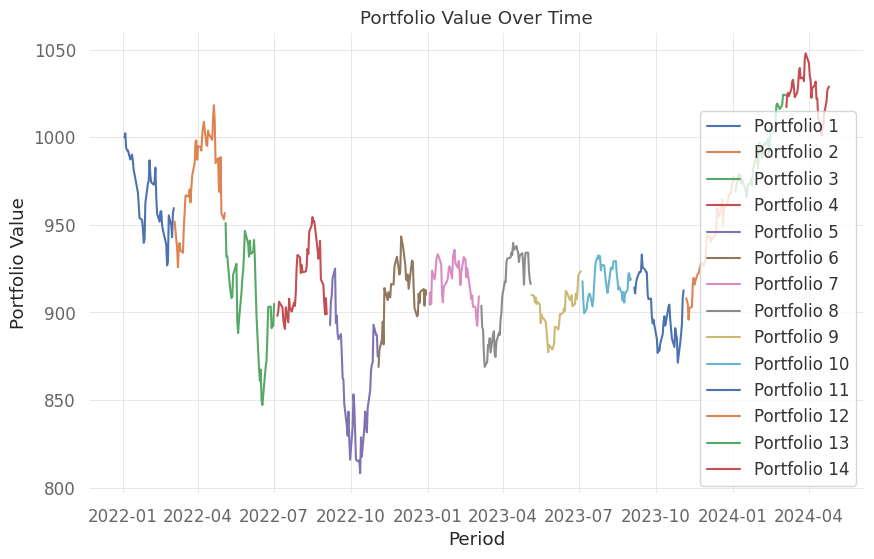

In [ ]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(bl_portfolio):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

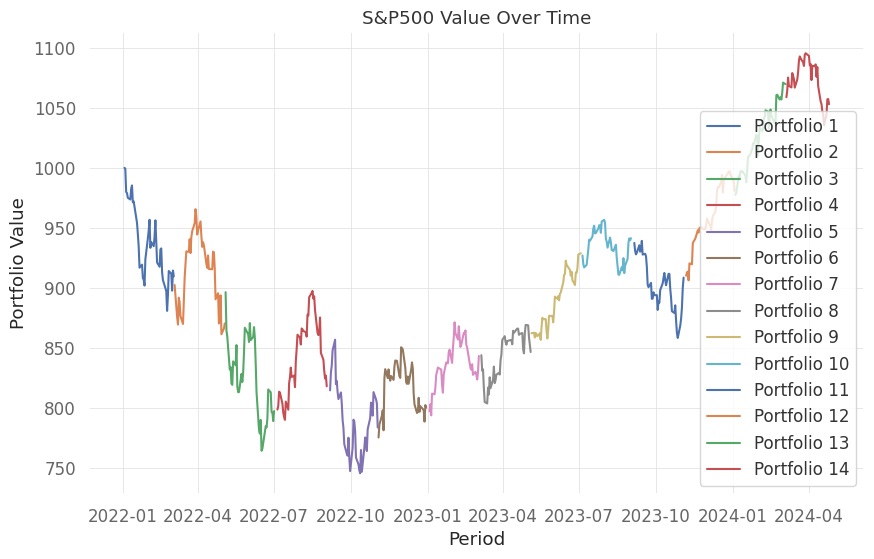

In [ ]:
# Plot each array in bl_portfolio
for i, portfolio_values in enumerate(market):
    plt.plot(portfolio_values, label=f'Portfolio {i+1}')

plt.xlabel('Period')
plt.ylabel('Portfolio Value')
plt.title('S&P500 Value Over Time')
plt.legend()
plt.show()

In [ ]:
#convert to a dataframe
df_portfolio=pd.DataFrame(bl_portfolio)
# Replace all the nan to value 0. When you do a dataframe it will create several row per each run and the columns are the dates
df_portfolio.fillna(0, inplace=True)

#transpose to have the date as row and all the run as columns
df_portfolio = df_portfolio.transpose()
#sum all the columns in the same row to have and unique value per row
df_portfolio = df_portfolio.sum(axis=1)

start= fecha
start_date = datetime.strptime(start, "%Y-%m-%d")
end_date = start_date + timedelta(days=leng_period*periods)
end = end_date.strftime("%Y-%m-%d")
sp500 = yf.download("^GSPC",start=start,end=end)['Adj Close']
market=sp500/sp500[0]*Total_invest_market

[*********************100%%**********************]  1 of 1 completed


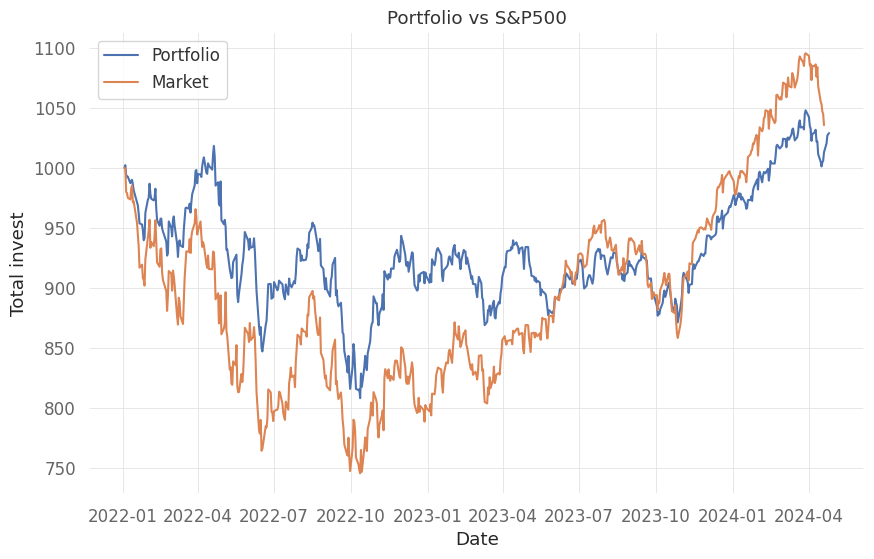

In [ ]:
# Plot df_portfolio
plt.plot(df_portfolio.index, df_portfolio, label='Portfolio')
plt.xlabel('Date')
plt.ylabel('Total invest')
plt.title('Portfolio vs S&P500')

# Plot market
plt.plot(market.index, market, label='Market')

# Add legend
plt.legend()

# Show the plot
plt.show()

## Weight distribution for all periods

In [ ]:
df=pd.DataFrame(weights, columns=assets)

In [ ]:
import plotly.express as px

# Assuming df is your DataFrame with data
fig = px.bar(df, barmode='stack')
fig.update_layout(
    title='Stacked Bar Chart',
    xaxis=dict(title='Category'),
    yaxis=dict(title='Values'),
    legend=dict(title='Assets'),
)
# Create dropdown menu for variable selection
buttons = [
    dict(label=var, method='update', args=[{'visible': [col == var for col in df.columns]}])
    for var in df.columns
]
# Add an option to reset the graph
buttons.append(
    dict(label="Reset", method="update", args=[{'visible': [True] * len(df.columns)}])
)

fig.update_layout(
    updatemenus=[
        dict(
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.1,
            xanchor='left',
            y=1.15,
            yanchor='top'
        ),
    ]
)
fig.show()

In [ ]:
hapi

[7.6499999999999995,
 5.7,
 6.8999999999999995,
 6.1499999999999995,
 5.85,
 5.85,
 5.3999999999999995,
 6.1499999999999995,
 5.7,
 4.95,
 4.5,
 6.45,
 6.75,
 6.75]

In [ ]:
print('Total cost fee USD',sum(hapi))
print('% cost total investment', sum(hapi)/1_000 *100 )
print('Total % return', (df_portfolio[-1]-df_portfolio[0])/df_portfolio[0]*100)
print('S&P 500 % return', (market[-1]-market[0])/market[0]*100)

Total cost fee USD 84.75000000000001
% cost total investment 8.475000000000001
Total % return 2.8946818656891655
S&P 500 % return 3.5581733531975717


In [ ]:
#3 months results
#Total cost fee USD 12.45
#% cost total investment 1.2449999999999999
#Total % return 44.64566895594882
#S&P 500 % return 9.27685093331147

In [ ]:
# Define the threshold value
threshold = 0.001
transposed_df = df.transpose()
# Apply boolean indexing to filter values higher than the threshold
filtered_df = transposed_df[transposed_df > threshold]
filtered_df = filtered_df.dropna(axis=0, thresh=1)
filtered_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
AAL,0.002546,0.002821,0.002942,0.002472,0.002395,0.003411,0.007081,0.004888,0.004076,0.005639,0.005657,0.006154,0.004470,0.006137
AEP,0.024991,0.046811,0.021565,0.027217,0.034504,0.020627,0.028105,0.019169,0.015253,0.012315,0.012627,0.023462,0.017024,0.011220
AMD,0.003094,0.002376,0.002336,0.002187,0.002741,0.002604,0.002650,0.002439,0.002650,0.002710,0.002737,0.002690,0.007243,0.005064
AMGN,0.020255,0.024415,0.036917,0.043457,0.039192,0.058954,0.043036,0.048879,0.041338,0.042046,0.033672,0.025102,0.029790,0.025132
AMT,0.021012,0.017792,0.016278,0.014983,0.016065,0.022428,0.014382,0.010354,0.012414,0.018173,0.009781,0.018094,0.011767,0.012761
AMZN,0.011050,0.007034,0.008821,0.004499,0.004028,0.005521,0.006979,0.004244,0.004487,0.005695,0.006399,0.008409,0.006610,0.007651
AXP,0.007958,0.008084,0.010536,0.007178,0.012155,0.014372,0.014718,0.009248,0.010519,0.009765,0.012472,0.020009,0.011096,0.012721
BAC,0.008315,0.009393,0.007818,0.011261,0.009237,0.009272,0.010125,0.012355,0.010954,0.011551,0.011392,0.009551,0.016648,0.008892
BLDR,0.006637,0.008507,0.004718,0.006634,0.004927,0.006148,0.004471,0.004715,0.005421,0.005097,0.005921,0.004589,0.005518,0.004444
BP,0.008041,0.008626,0.017515,0.009784,0.010818,0.016753,0.012228,0.018840,0.013063,0.014137,0.013145,0.022466,0.026498,0.013935


In [ ]:
filtered_df.shape

(55, 14)

## Fama Fench evaluation

In [ ]:
pip install getFamaFrenchFactors

In [ ]:
import getFamaFrenchFactors as gff

# Get the Fama French 3 factor model (monthly data)
df_ff3_monthly = gff.famaFrench3Factor(frequency='m')
df_ff3_monthly

,date_ff_factors,Mkt-RF,SMB,HML,RF
0,1926-07-31,0.0296,-0.0256,-0.0243,0.0022
1,1926-08-31,0.0264,-0.0117,0.0382,0.0025
2,1926-09-30,0.0036,-0.0140,0.0013,0.0023
3,1926-10-31,-0.0324,-0.0009,0.0070,0.0032
4,1926-11-30,0.0253,-0.0010,-0.0051,0.0031
...,...,...,...,...,...
1167,2023-10-31,-0.0319,-0.0387,0.0019,0.0047
1168,2023-11-30,0.0884,-0.0002,0.0164,0.0044
1169,2023-12-31,0.0487,0.0634,0.0493,0.0043
1170,2024-01-31,0.0071,-0.0509,-0.0238,0.0047


In [ ]:
# Convert date_ff_factors to datetime format
df_ff3_monthly['date_ff_factors'] = pd.to_datetime(df_ff3_monthly['date_ff_factors'])

# Set the date as the index
df_ff3_monthly.set_index('date_ff_factors', inplace=True)

# Resample to daily frequency
#df_ff3_daily = df_ff3_monthly.resample('D').asfreq()

# Forward-fill NaN values for daily frequency
#df_ff3_daily.fillna(method='ffill', inplace=True)

In [ ]:
# Get the portfolio returns
portfolio_returns=pd.DataFrame(df_portfolio.pct_change())

In [ ]:
fama_fench = portfolio_returns.merge(df_ff3_monthly, how='inner', left_index=True, right_index=True) # Join the Fama Fench factors with portfolio returns
fama_fench = fama_fench.dropna()
# Calculate excess return of portfolio
fama_fench['Excess Return'] = fama_fench[0] - fama_fench['RF']

In [ ]:
fama_fench

,0,Mkt-RF,SMB,HML,RF,Excess Return
2022-01-31,0.011235,-0.0625,-0.0594,0.1275,0.0000,0.011235
2022-02-28,-0.005854,-0.0229,0.0219,0.0308,0.0000,-0.005854
2022-03-31,-0.011073,0.0305,-0.0161,-0.0181,0.0001,-0.011173
2022-05-31,-0.007701,-0.0034,-0.0183,0.0839,0.0003,-0.008001
2022-06-30,-0.000393,-0.0843,0.0210,-0.0597,0.0006,-0.000993
2022-08-31,-0.007646,-0.0377,0.0140,0.0029,0.0019,-0.009546
2022-09-30,-0.013482,-0.0935,-0.0081,0.0005,0.0019,-0.015382
2022-10-31,-0.006548,0.0783,0.0006,0.0801,0.0023,-0.008848
2022-11-30,0.020974,0.0460,-0.0352,0.0138,0.0029,0.018074
2023-01-31,0.012717,0.0665,0.0501,-0.0401,0.0035,0.009217


In [ ]:
# Define the independent variables (adding a constant for the intercept)
X = fama_fench[['Mkt-RF', 'SMB', 'HML']]
X = sm.add_constant(X)

# Define the dependent variable
y = fama_fench['Excess Return']

# Perform the regression analysis
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess Return   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                 -0.016
Method:                 Least Squares   F-statistic:                    0.8994
Date:                Thu, 25 Apr 2024   Prob (F-statistic):              0.463
Time:                        18:02:53   Log-Likelihood:                 67.608
No. Observations:                  20   AIC:                            -127.2
Df Residuals:                      16   BIC:                            -123.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0030      0.002     -1.395      0.1

In [ ]:
!pip install QuantStats

[Performance Metrics]

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2022-01-05   2022-01-05
End Period                 2024-04-25   2024-04-25
Risk-Free Rate             0.0%         0.0%
Time in Market             18.0%        100.0%

Cumulative Return          -100.0%      2.66%
CAGR﹪                     -100.0%      0.79%

Sharpe                     -0.75        0.15
Prob. Sharpe Ratio         0.72%        59.08%
Smart Sharpe               -0.71        0.14
Sortino                    -0.75        0.21
Smart Sortino              -0.71        0.2
Sortino/√2                 -0.53        0.15
Smart Sortino/√2           -0.5         0.14
Omega                      1.03         1.03

Max Drawdown               -100.0%      -20.62%
Longest DD Days            834          673
Volatility (ann.)          66.74%       13.9%
R^2                        0.01         0.01
Information Ratio          0.05         0.05


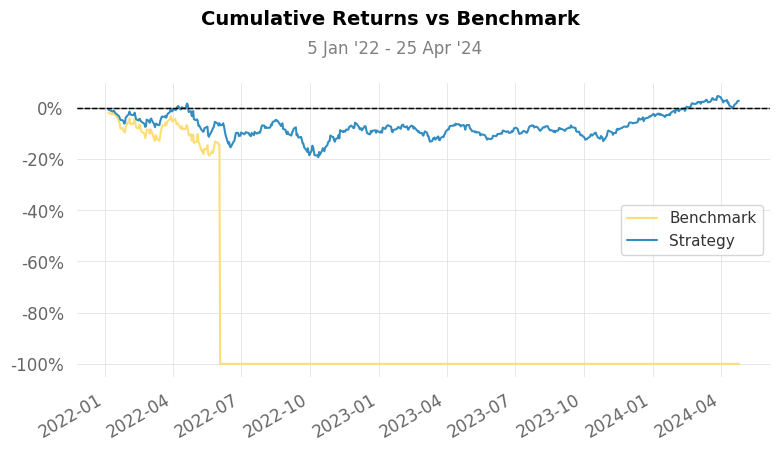

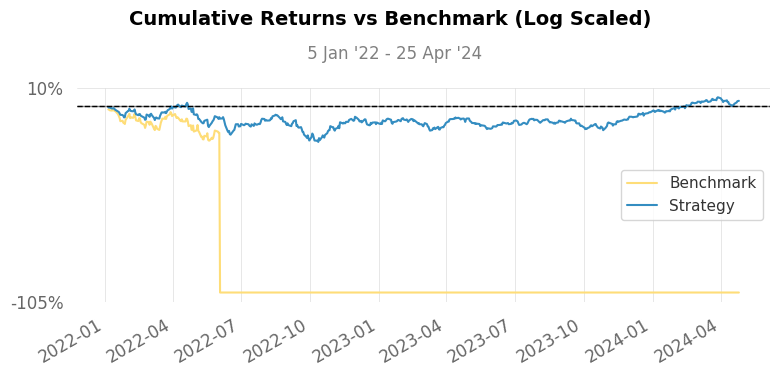

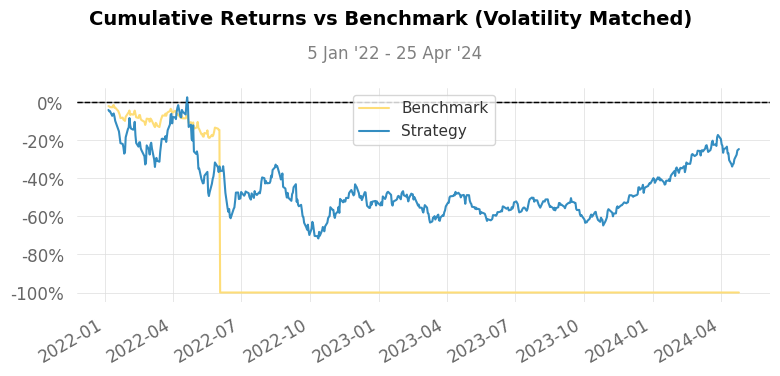

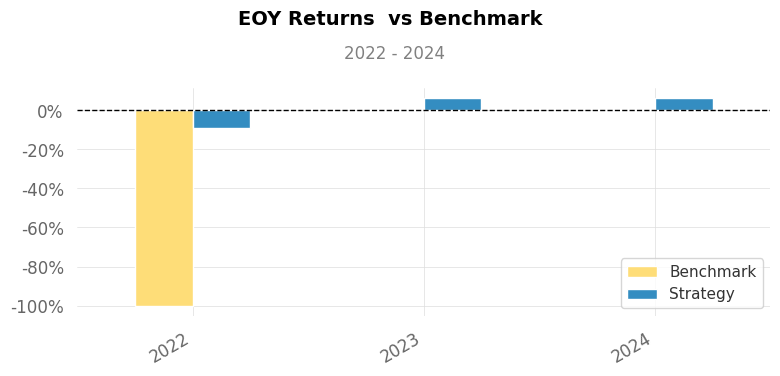

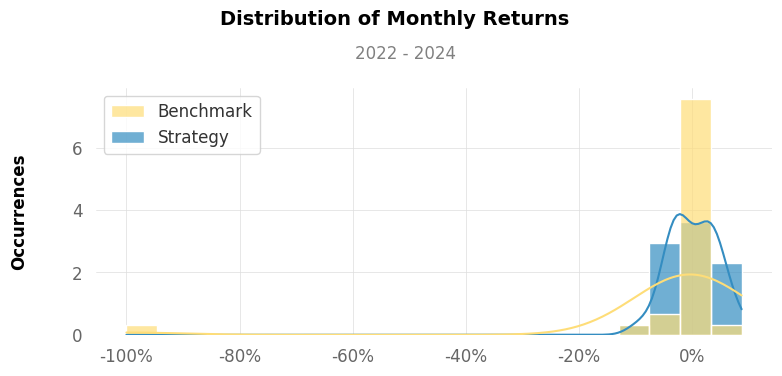

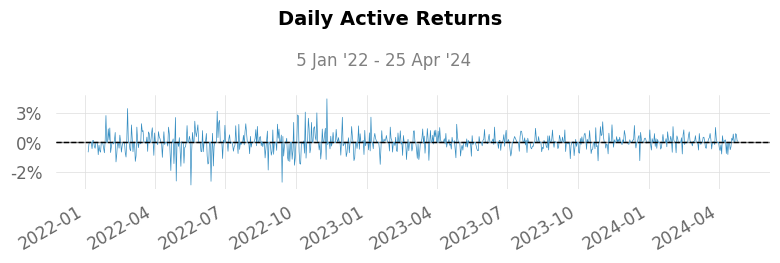

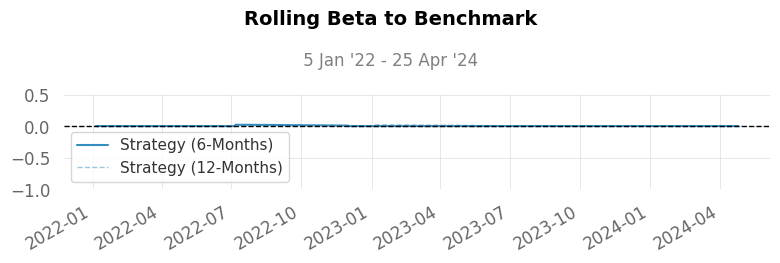

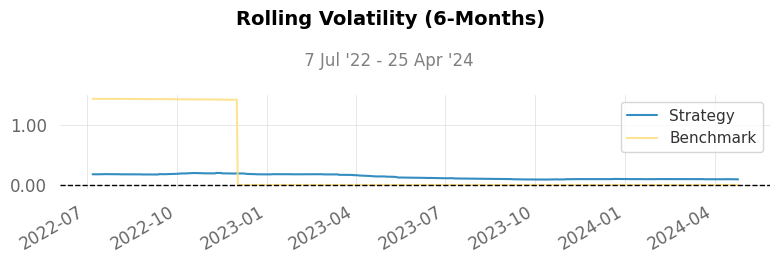

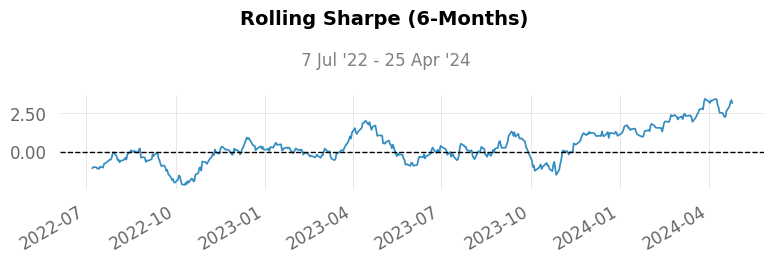

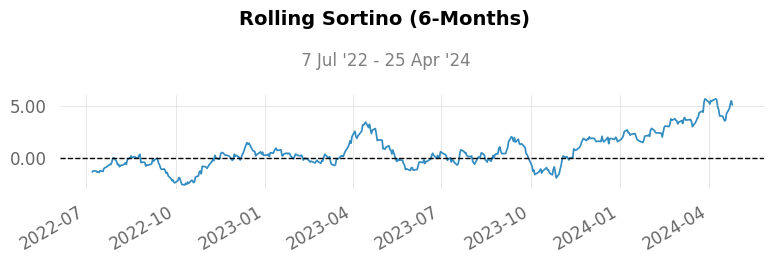

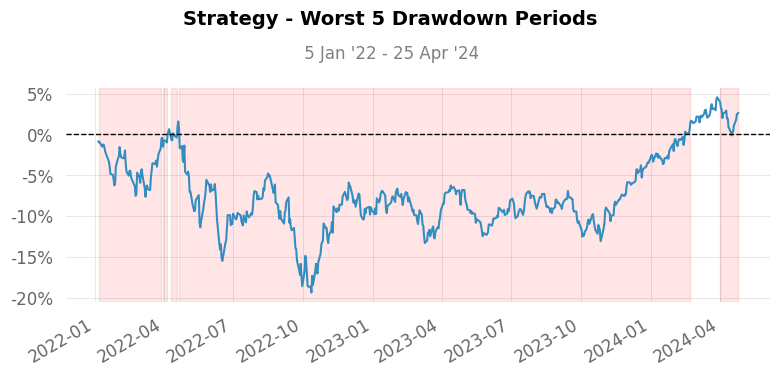

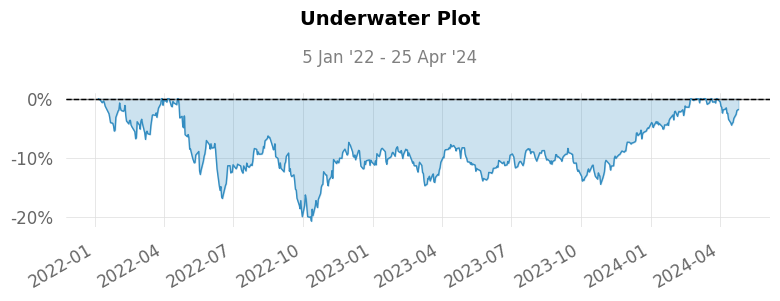

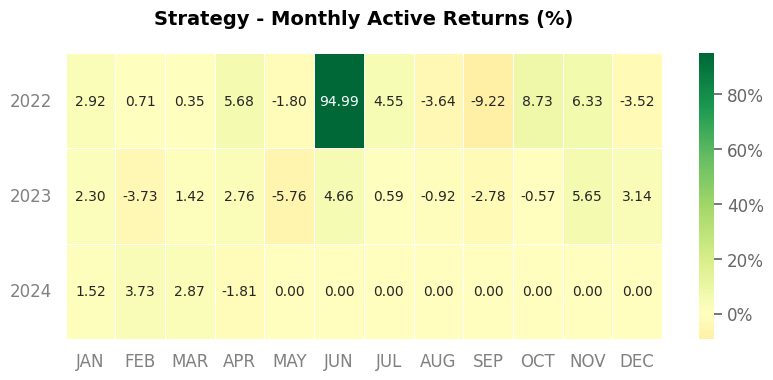

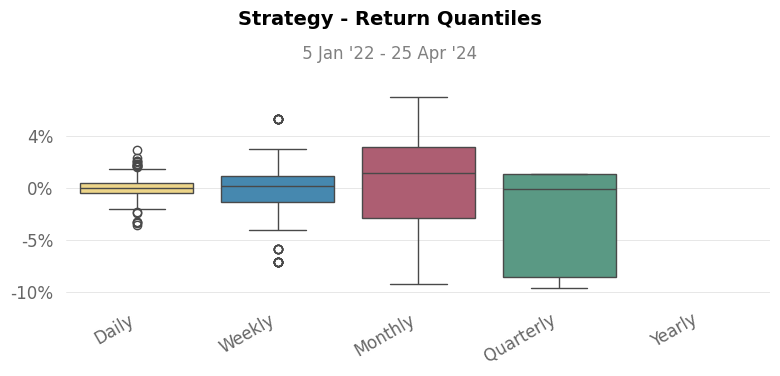

In [ ]:
import quantstats as qs
qs.reports.full(df_portfolio, benchmark = market)